# Среднемесячная зарплата в России

In [2]:
import statsmodels
statsmodels.__version__

'0.8.0'

In [3]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib
-f
C:\Users\Cherry\AppData\Roaming\jupyter\runtime\kernel-01138bee-2ca5-4ab4-b618-160cbda33e5d.json


C:\Users\Cherry\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


             salary
month              
1993-01-01  15300.0
1993-02-01  19100.0
1993-03-01  23600.0
1993-04-01  30600.0
1993-05-01  37500.0


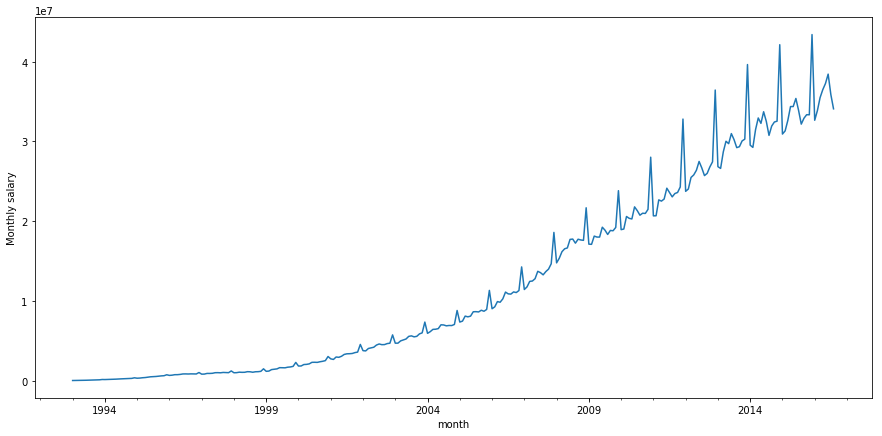

In [11]:
df = pd.read_csv('WAG_C_M.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.rename(columns = {'WAG_C_M': 'salary'}, inplace = True)
print df.head()
df.salary = df.salary*1000
print df.head()
plt.figure(figsize(15,7))
df.salary.plot()
plt.ylabel('Monthly salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


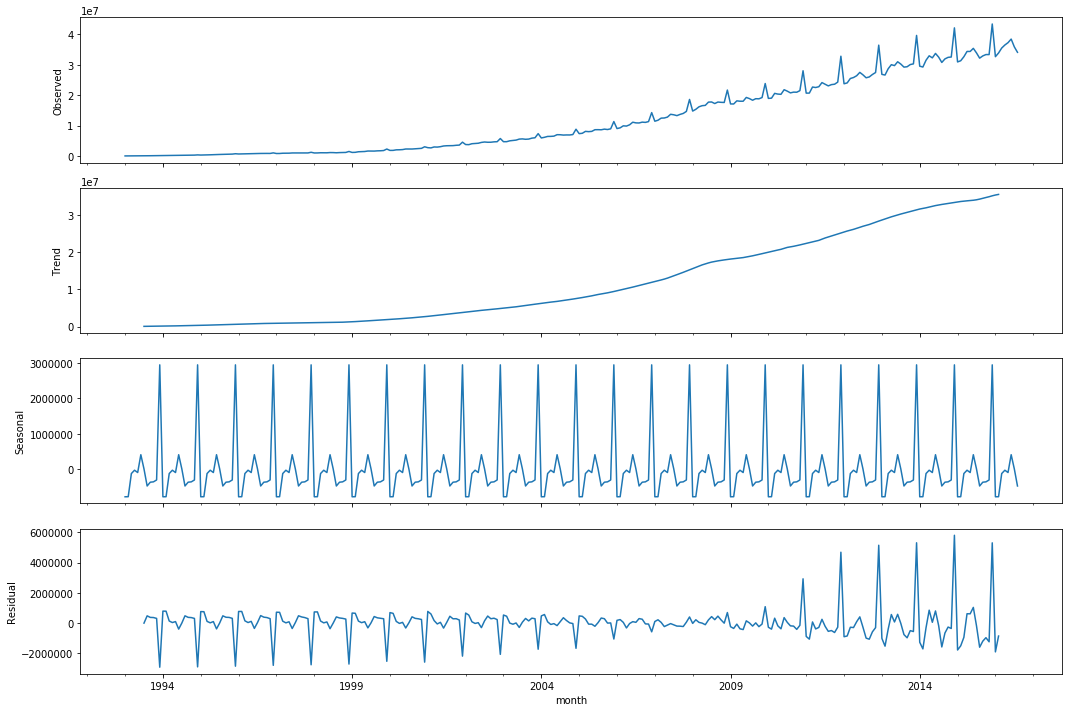

In [12]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary)[1])

Ряд нестационарен. Очевиден возрастающий тренд, в остатках много структуры

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии (размах колебаний увеличивается):

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


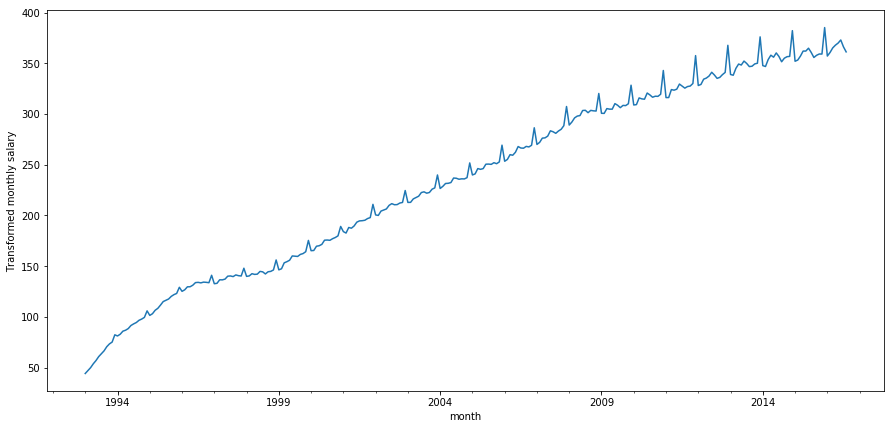

In [13]:
df['salary_box'], lmbda = stats.boxcox(df.salary)
plt.figure(figsize(15,7))
df.salary_box.plot()
plt.ylabel(u'Transformed monthly salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box)[1])

### Стационарность

Преобразованный ряд нестационарный. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


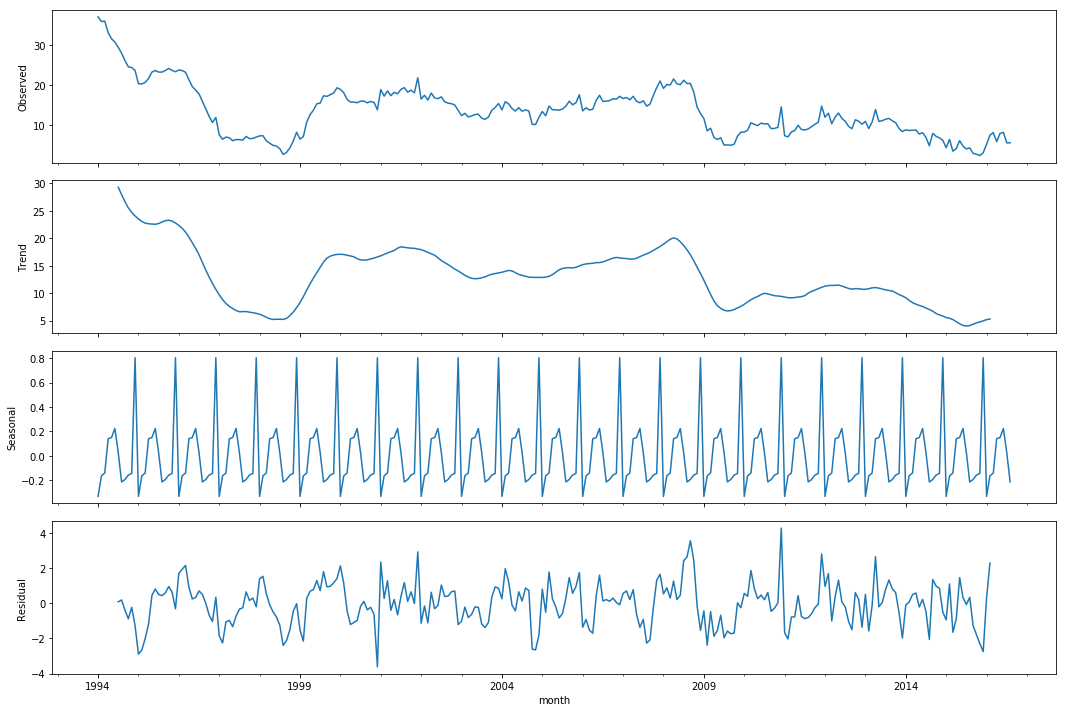

In [14]:
df['salary_box_diff'] = df.salary_box - df.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем добавить обычное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.000000


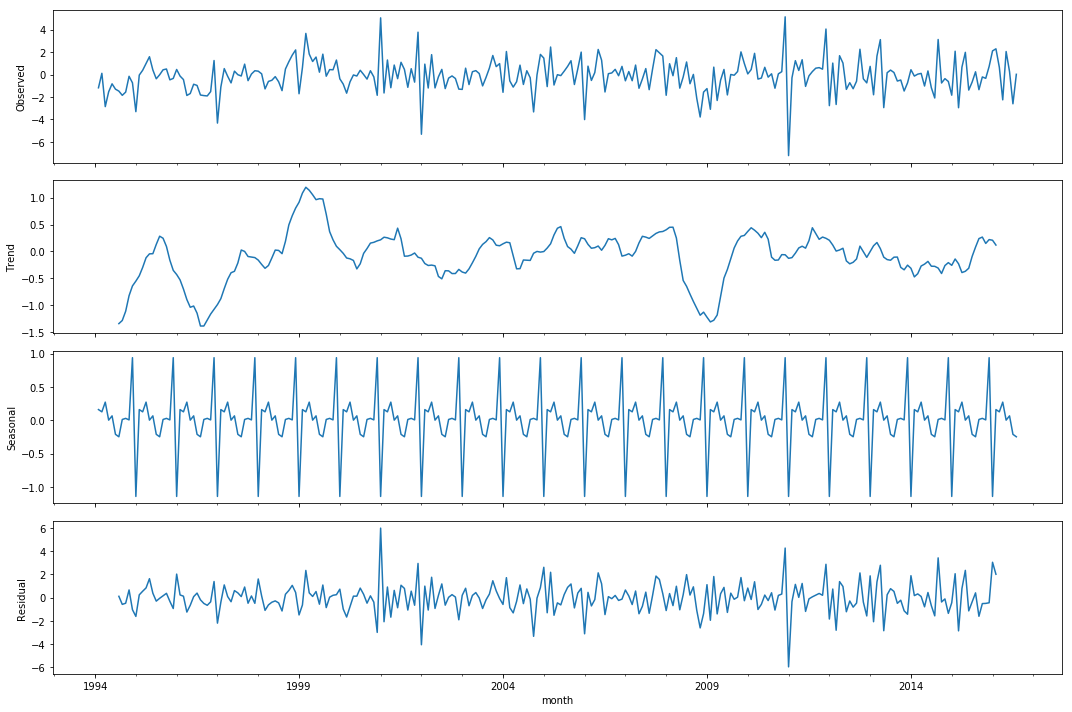

In [15]:
df['salary_box_diff2'] = df.salary_box_diff - df.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

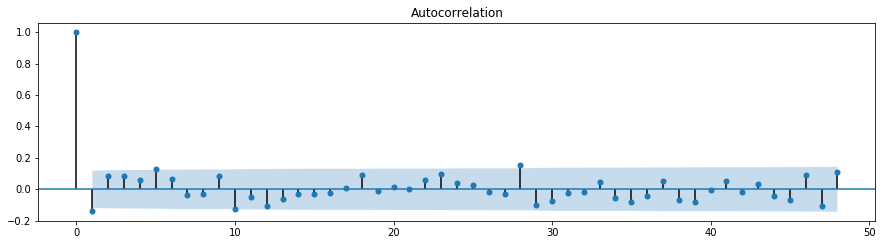

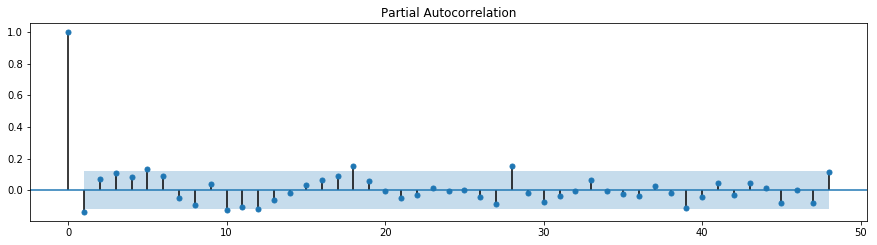

In [16]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=5, P=4, p=5. q и p выбирать большими не будем (10 или 11), чтобы не усложнять модель и подбор наилучшей.

In [17]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

In [18]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

360

In [21]:
parameters_list[0]

(0, 0, 0, 0)

In [41]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 2, 1))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 3, 1))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (1, 2, 4, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 4, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 2, 1))
('wrong parameters:', (2, 2,

In [42]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
227  (5, 5, 4, 1)  955.094265
221  (5, 5, 1, 0)  959.430605
220  (5, 5, 0, 1)  960.017435
222  (5, 5, 1, 1)  960.472746
223  (5, 5, 2, 0)  960.726822


In [43]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(4, 1, 1, 12)   Log Likelihood                -461.547
Date:                            Sun, 23 Jun 2019   AIC                            955.094
Time:                                    01:44:20   BIC                           1013.478
Sample:                                01-01-1993   HQIC                           978.501
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0541      1.727      0.031      0.975      -3.331       3.439
ar.L2         -0.0063      1.223   

Её остатки:

Критерий Стьюдента: p=0.579605
Критерий Дики-Фуллера: p=0.000000


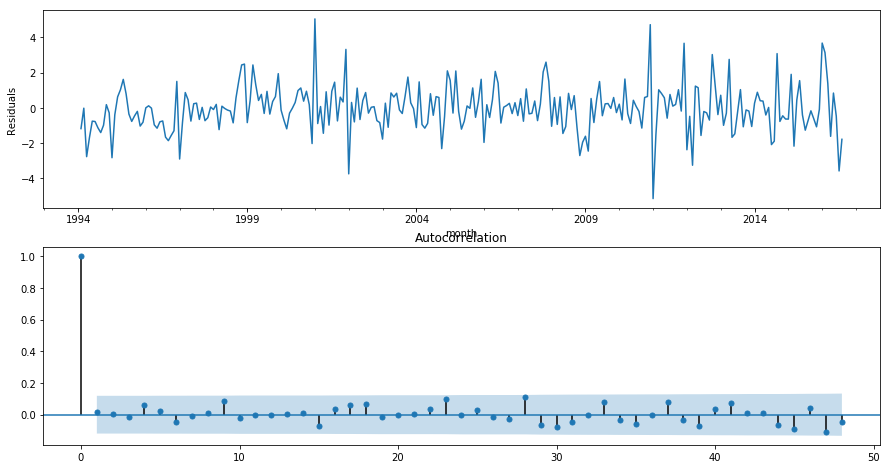

In [44]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

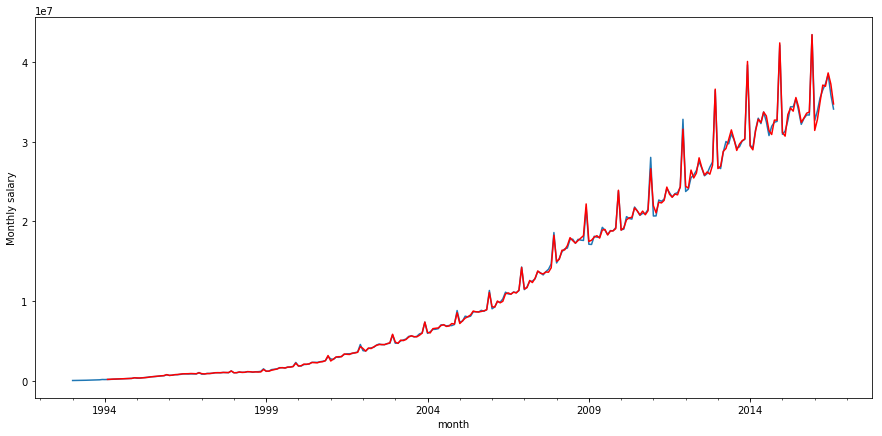

In [45]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.salary.plot()
df.model[13:].plot(color='r')
plt.ylabel('Monthly salary')
pylab.show()

In [46]:
df[-5:]

,salary,salary_box,salary_box_diff,salary_box_diff2,model
month,,,,,
2016-04-01,36497000.0,367.830360,5.807537,-2.255980,3.710596e+07
2016-05-01,37270000.0,369.886066,7.854840,2.047303,3.695379e+07
2016-06-01,38447000.0,372.956651,8.113139,0.258299,3.863138e+07
2016-07-01,35888000.0,366.188082,5.505322,-2.607817,3.722845e+07
2016-08-01,34095000.0,361.230584,5.523488,0.018166,3.473496e+07


### Прогноз

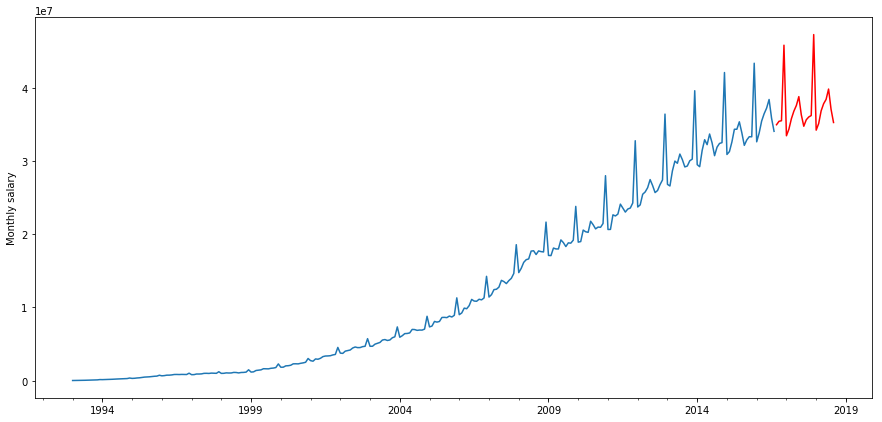

In [47]:
df2 = df[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=df.shape[0], end=df2.shape[0]-1), lmbda)

plt.figure(figsize(15,7))
df2.salary.plot()
df2.forecast.plot(color='r')
plt.ylabel('Monthly salary')
pylab.show()

### Сравним прогноз с фактическими значениями

              salary
month               
2016-09-01  35843000
2016-10-01  35749000
2016-11-01  36195000
2016-12-01  47554000
2017-01-01  34422000


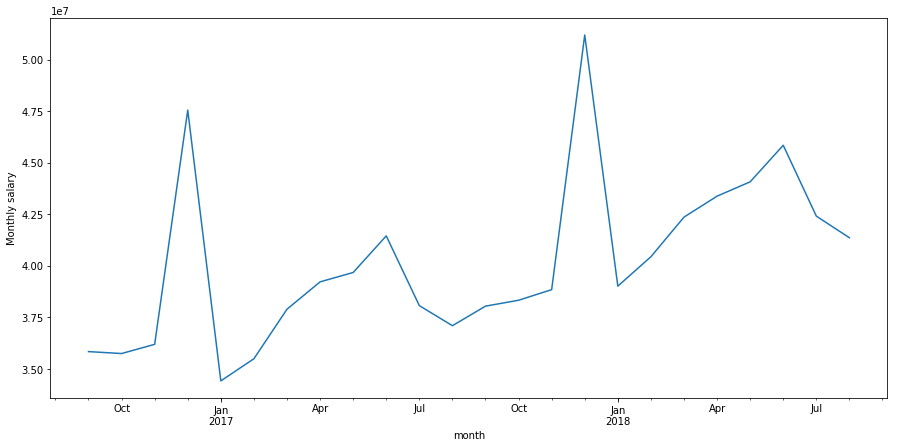

In [48]:
df_ = pd.read_csv('new_salary_data.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
df_.salary = df_.salary*1000
print df_.head()
plt.figure(figsize(15,7))
df_.salary.plot()
plt.ylabel('Monthly salary')
pylab.show()

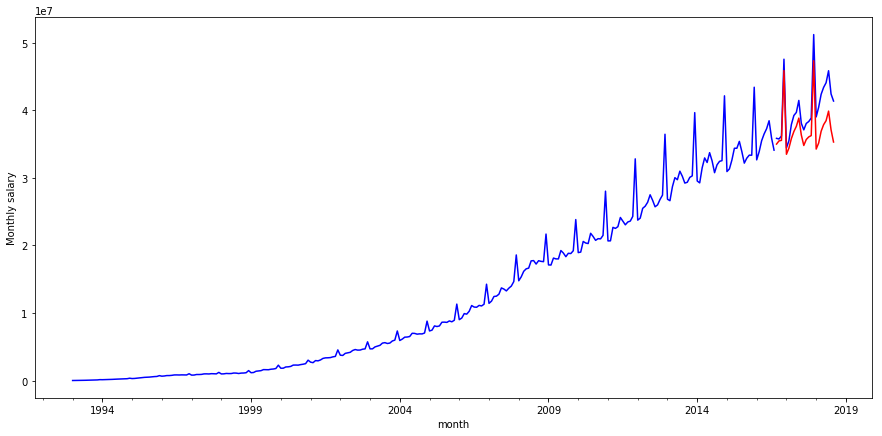

In [49]:
plt.figure(figsize(15,7))
df2.salary.plot(color = 'b')
df_.salary.plot(color = 'b')
df2.forecast.plot(color='r')
plt.ylabel('Monthly salary')
pylab.show()